<div style="border:solid black 2px; padding: 20px"><h1 style="color:black; margin-bottom:20px">Reviewer's comment v1</h1>
Halo Teguh !

Perkenalkan saya disini sebagai Code Reviewers, disini dengan senang hati saya akan mereview tugas Teguh ya.

Saya akan memberikan beberapa komen seperti dibawah ini, tolong jangan dipindah, dirubah, maupun dihapus ya.

Komen yang saya berikan akan muncul dalam warna hijau, kuning, atau pun merah seperti ini:

<div class="alert alert-success">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Bagus, code yang dijalankan sudah sesuai dengan instruksi dari project.

</div>

<div class="alert alert-warning">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Terdapat beberapa catatan.

</div>

<div class="alert alert-danger">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Perlu beberapa perbaikan

</div>

Dan tentu saja Teguh dapat menjawab saya dengan menggunakan ini

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>
    
Baik kak
</div>

# Deskripsi tugas

Perusahaan taksi bernama Sweet Lift telah mengumpulkan data historis tentang pesanan taksi di bandara. Untuk menarik lebih banyak pengemudi pada jam sibuk, perlu memprediksi jumlah pesanan taksi untuk satu jam berikutnya. Buat model untuk prediksi seperti itu.

Metrik RMSE pada *test set* tidak boleh lebih dari 48.

## Instruksi tugas

1. Unduh data dan lakukan *resampling* dalam satu jam.
2. Analisis datanya.
3.  Latih model yang berbeda dengan hiperparameter yang berbeda pula. Sampel tes harus 10% dari *dataset* awal.
4. Uji data menggunakan sampel tes dan berikan kesimpulan.

## Deskripsi data

Data tersimpan di file `taxi.csv`. Jumlah pesanan di kolom'*num_orders*'.

<div class="alert alert-success">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Bagus, code yang dijalankan sudah sesuai dengan instruksi dari project.

</div>

## Persiapan

### Mengimport Library

In [1]:
# mengimport library yang dibutuhkan
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import randint
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

### Memuat dan Pemahaman Tentang Data

In [2]:
# memuat data
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
# menampilkan 5 data pertama
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
# informasi umum data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
# memeriksa duplikat
df.duplicated().sum()

0

In [6]:
# memeriksa missing value
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [7]:
# statistika deskriptif
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
datetime,26496,26496,2018-08-28 16:50:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_orders,26496.0,NaN,NaN,NaN,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


Sepertinya data kita tidak memiliki *missing value* dan duplikat. Akan tetapi kita perlu mengubah kolom `datetime` ke tipe data `datetime`. 

<div class="alert alert-success">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Bagus, code yang dijalankan sudah sesuai dengan instruksi dari project.

</div>

### Memperbaiki Kualitas Data

Kita akan mengubah tipe data kolom `datetime` dan menjadikannya sebagai index serta memeriksa apakah kolom tersebut sudah berurutan sesuai tanggal apa bukan. Lalu yang terakhir adalah meresampling data kedalam rentang waktu 1 jam.

In [8]:
# mengubah tipe data kolom datetime
df['datetime'] = pd.to_datetime(df['datetime'])

In [9]:
# mengatur kolom datetime sebagai index
df.set_index('datetime', inplace=True)

In [10]:
# mengatur ulang agar index menjadi urutan naik
df = df.sort_index()

In [11]:
# memeriksa apakah index sudah sesuai urutan kronologis
df.index.is_monotonic

True

In [12]:
# memeriksa kembali informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Sekarang kita telah memiliki data yang siap untuk dianalisis. 

<div class="alert alert-success">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Bagus, code yang dijalankan sudah sesuai dengan instruksi dari project.

</div>

## Analisis

In [13]:
#
def plot_with_ma(data, title):
    data['rolling_mean'] = data.rolling(10).mean()
    # ukuran plot
    fig, axes= plt.subplots(figsize=(15, 5)) 

    # memplot total orders dalam interval 1 jam
    axes.plot(data.index, data['num_orders'], color='blue', alpha=0.6, label='Orders')  
    axes.plot(data.index, data['rolling_mean'], color='red', label='Moving Averages', linestyle='--')
    # pengaturan
    plt.legend()
    plt.xlabel('Waktu')
    plt.ylabel('Jumlah')
    plt.title(title, size=15, fontweight='bold')
    plt.xticks(rotation=45) 
    plt.show()
#
def decomposed_plot(data):
    plt.figure(figsize=(15, 15)) 

    decomposed = seasonal_decompose(data['num_orders'])
    ## trend
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend', size=15, fontweight='bold')
    ## seasonal
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality', size=15, fontweight='bold')
    ## residu
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals', size=15, fontweight='bold')
    plt.tight_layout()

### Analisis Data Interval Satu Jam

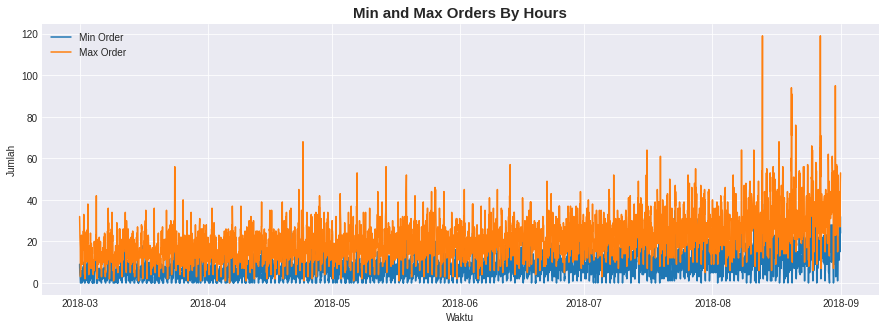

In [14]:
# visualisasi min max orders dalam interval 1 jam
plt.style.use('seaborn-darkgrid')
#
fig, axes = plt.subplots(figsize=(15, 5))

axes.plot(df.resample('1H').min(), label='Min Order')
axes.plot(df.resample('1H').max(), label='Max Order')
plt.xlabel('Waktu')
plt.ylabel('Jumlah')
plt.title('Min and Max Orders By Hours', size=15, fontweight='bold')
plt.legend()
plt.show()

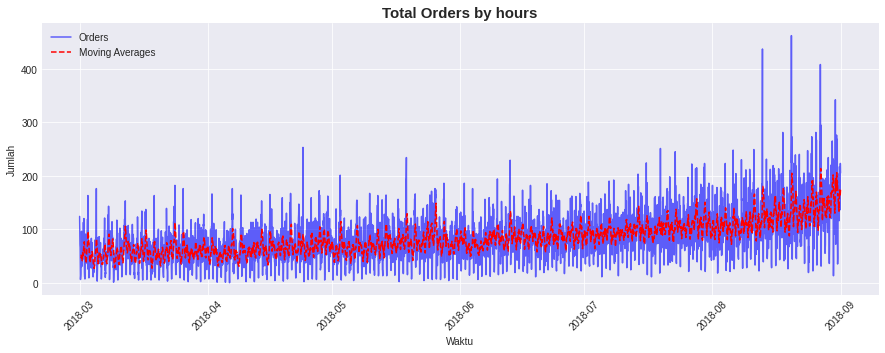

In [15]:
# resampling data ke interval 1 jam
hours_data = df.resample('1H').sum()
# visualisasi
plot_with_ma(hours_data, 'Total Orders by hours')

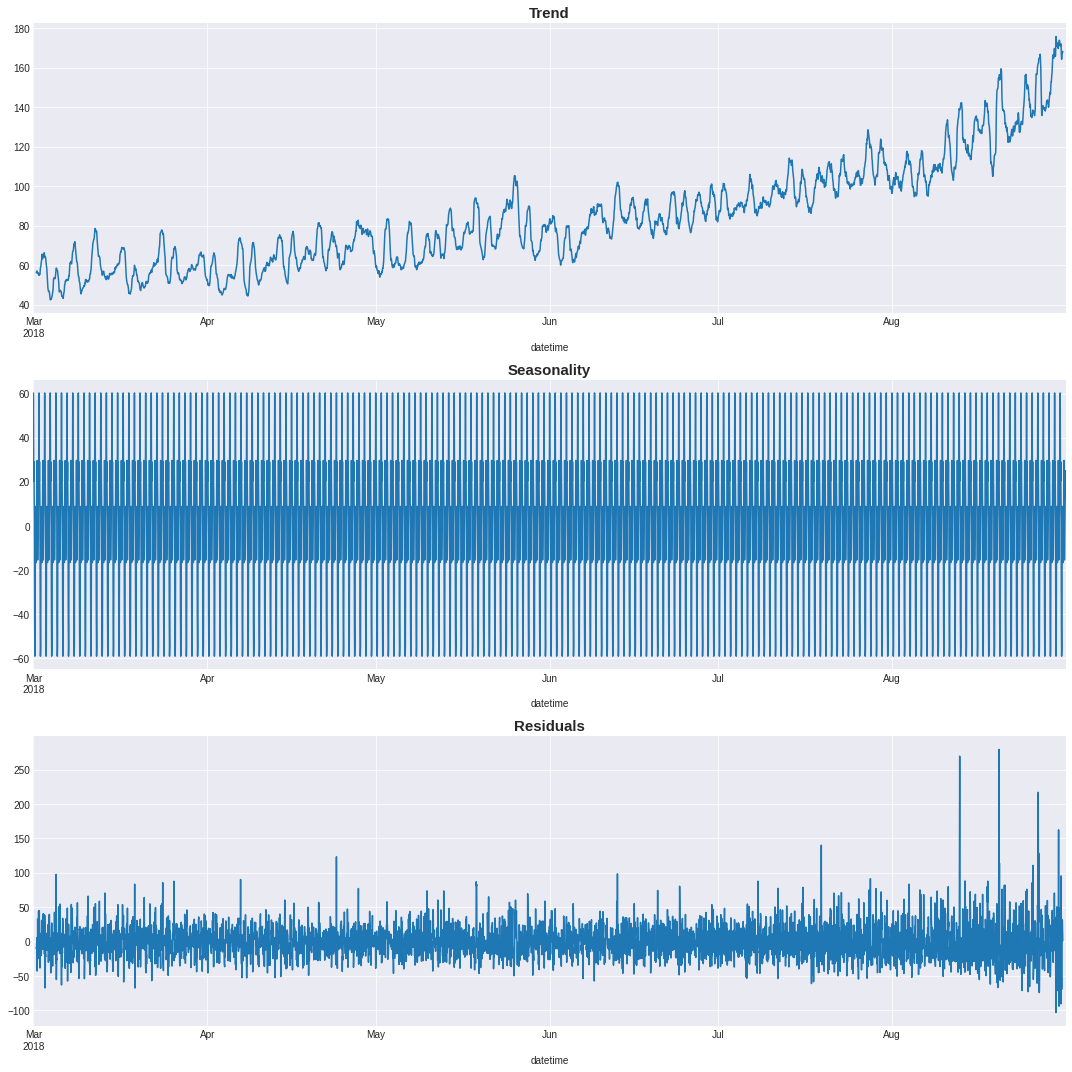

In [16]:
# decomposed plot untuk data interval 1 jam
decomposed_plot(hours_data)

Sepertinya data kita terlalu banyak variabilitas sehingga sedikit sulit untuk merepresentasikan kesimpulan yang lebih dalam, tetapi secara umum dataset kita memiliki trend naik (positive). Kita akan mencoba mengambil sample dan menganalisis data dalam dua hari.

<div class="alert alert-success">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Bagus, code yang dijalankan sudah sesuai dengan instruksi dari project.

</div>

#### Sample Data 2 hari

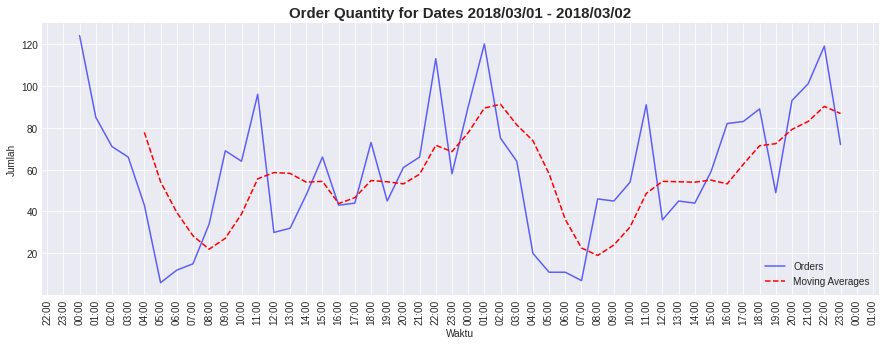

In [17]:
# mengambil sample data untuk 2 hari
twod_data = hours_data.loc['2018-03-01':'2018-03-02'].copy()
#
twod_data['rolling_mean'] = twod_data['num_orders'].rolling(5).mean()

# ukuran plot
fig, axes = plt.subplots(figsize=(15, 5)) 

# memplot total orders dalam interval 1 jam
axes.plot(twod_data.index, twod_data['num_orders'], color='blue', alpha=0.6, label='Orders')  
axes.plot(twod_data.index, twod_data['rolling_mean'], color='red', label='Moving Averages', linestyle='--')

# pengaturan sumbu x
axes.xaxis.set_major_locator(mdates.HourLocator(interval=1))  
axes.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  

# pengaturan lainnya
plt.legend()
plt.xlabel('Waktu')
plt.ylabel('Jumlah')
plt.title('Order Quantity for Dates 2018/03/01 - 2018/03/02', size=15, fontweight='bold')
plt.xticks(rotation=90) 
plt.show()

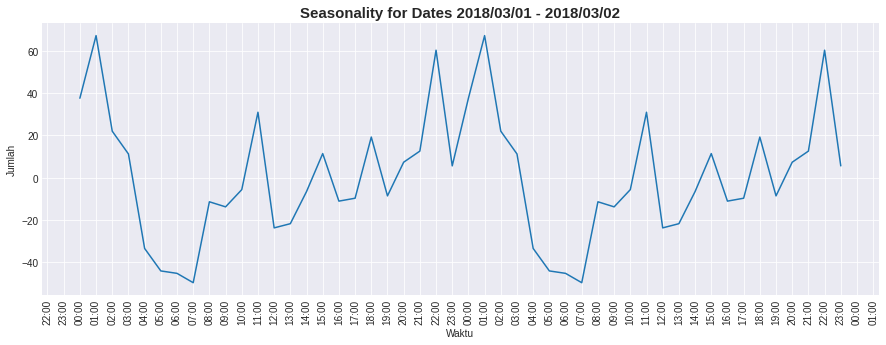

In [18]:
fig, axes = plt.subplots(figsize=(15, 5)) 

decomposed_day = seasonal_decompose(twod_data['num_orders'])

axes.plot(decomposed_day.seasonal)
# pengaturan sumbu x
axes.xaxis.set_major_locator(mdates.HourLocator(interval=1))  
axes.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  

# pengaturan lainnya
plt.xlabel('Waktu')
plt.ylabel('Jumlah')
plt.title('Seasonality for Dates 2018/03/01 - 2018/03/02', size=15, fontweight='bold')
plt.xticks(rotation=90) 
plt.show()

Berdasarkan sample untuk 2 hari kita mendapatkan bahwa jumlah pesanan taksi paling sedikit berada diantara pukul 04:00 hingga pukul 07:00 dan setelah itu terus terjadi peningkatan jumlah pesanan yang berakhir pada pukul 01.00 dimana ini merupakan waktu produktifitas semua orang.

<div class="alert alert-success">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Bagus, code yang dijalankan sudah sesuai dengan instruksi dari project.

</div>

### Analisis Data Interval Satu Hari

Sebelumnya kita sudah mengetahui bagaimana pola dalam tingkat pesana taksi dari data yang kita miliki berdasarkan data interval satu jam. Selanjutnya kita akan mencoba menganalisa data dalam interval satu hari dan mengambil sampel dalam waktu 7 hari dari data.

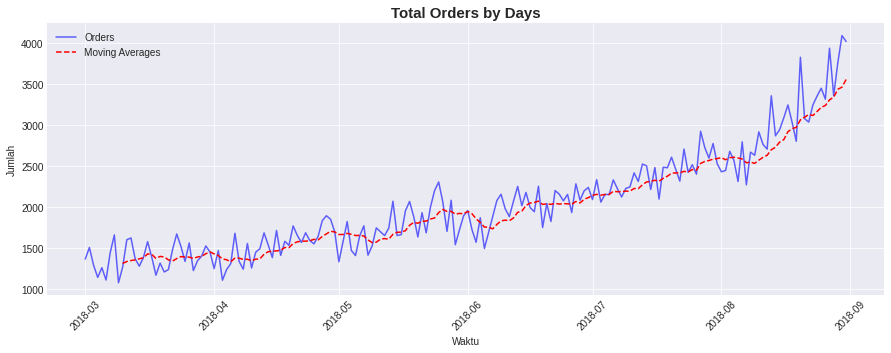

In [19]:
daily_data = df.resample('1D').sum()
# visualisasi
plot_with_ma(daily_data, 'Total Orders by Days')

#### Sample Data 15 Hari

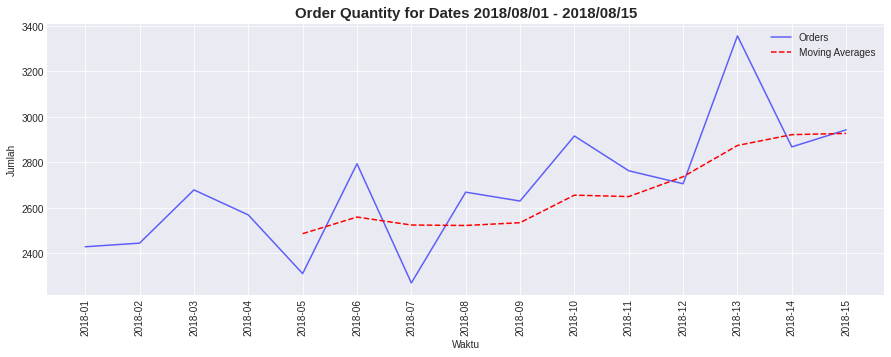

In [20]:
# mengambil sample data untuk 14 hari
twoweek_data = daily_data.loc['2018-08-01':'2018-08-15'].copy()
#
twoweek_data['rolling_mean'] = twoweek_data['num_orders'].rolling(5).mean()

# ukuran plot
fig, axes = plt.subplots(figsize=(15, 5)) 

# memplot total orders dalam interval 1 jam
axes.plot(twoweek_data.index, twoweek_data['num_orders'], color='blue', alpha=0.6, label='Orders')  
axes.plot(twoweek_data.index, twoweek_data['rolling_mean'], color='red', label='Moving Averages', linestyle='--')

# pengaturan sumbu x
axes.xaxis.set_major_locator(mdates.DayLocator(interval=1))  
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%d'))  

# pengaturan lainnya
plt.legend()
plt.xlabel('Waktu')
plt.ylabel('Jumlah')
plt.title('Order Quantity for Dates 2018/08/01 - 2018/08/15', size=15, fontweight='bold')
plt.xticks(rotation=90) 
plt.show()

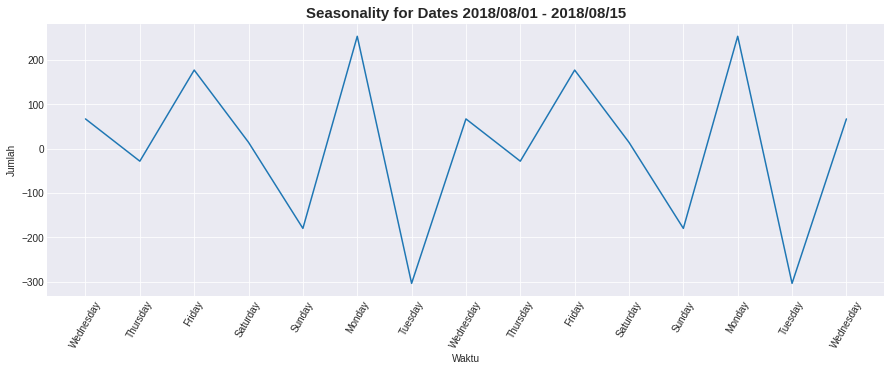

In [21]:
fig, axes = plt.subplots(figsize=(15, 5)) 

decomposed_day = seasonal_decompose(twoweek_data['num_orders'])

axes.plot(decomposed_day.seasonal)
# pengaturan sumbu x
axes.xaxis.set_major_locator(mdates.DayLocator(interval=1))
axes.xaxis.set_major_formatter(mdates.DateFormatter('%A'))  

# pengaturan lainnya
plt.xlabel('Waktu')
plt.ylabel('Jumlah')
plt.title('Seasonality for Dates 2018/08/01 - 2018/08/15', size=15, fontweight='bold')
plt.xticks(rotation=60) 
plt.show()

Dalam seasonality sepertinya menjelaskan bahwa data kita memiliki pola penurunan pesanan yang drastis terjadi pada hari minggu dan selasa, akan tetapi jumlah pesanan terbanyak selalu terjadi dihari senin.

<div class="alert alert-success">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Bagus, code yang dijalankan sudah sesuai dengan instruksi dari project.

</div>

### Pengujian Stasioner Pada Data

Sebelum kita melakukan modeling, kita akan menguji apakah data kita sudah stasioner atau belum. Jika belum, maka kita harus mengubah data deret waktu kita menjadi lebih stasioner agar bisa membantu dalam memprediksi data.

Untuk mengujinya kita akan menggunakan salah satu metode statistik yaitu menggunakan Augmented Dickey-Fuller (ADF) test. ADF test adalah tes yang umum digunakan untuk menguji apakah suatu deret waktu stasioner atau tidak. Nilai p-value yang dihasilkan dari ADF test akan membantu kita untuk menentukan apakah kita dapat menolak hipotesis nol (hipotesis bahwa data tidak stasioner) atau tidak.


Adapun bunyi dari hipotesis nol dan alternatifnya adalah sebagai berikut:

- H0: menyatakan bahwa deret waktu (time series) memiliki unit root atau **tidak stasioner**.
- H1: menyatakan bahwa deret waktu tidak memiliki unit root atau **stasioner**.

In [22]:
# dataset final yang akan dipakai
df = df.resample('1H').sum()
# uji dengan ADF
result = adfuller(df)
# Hasil dari ADF test
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
print(50*'-')
# Interpretasi hasil uji
if result[1] < 0.05:  # Menetapkan tingkat signifikansi 0.05
    print('Hasil uji menolak hipotesis nol.')
    print('Data adalah stasioner.')
else:
    print('Hasil uji gagal menolak hipotesis nol.')
    print('Data mungkin tidak stasioner.')

ADF Statistic: -3.068924289027954
p-value: 0.028940051402613028
Critical Values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
--------------------------------------------------
Hasil uji menolak hipotesis nol.
Data adalah stasioner.


### Kesimpulan Analisis

Setelah menganalisa data kita dapat melihat bahwa kecenderungan data ini memiliki trend yang naik (positive) walaupun kenaikannya tidak terlalu signifikan, akan tetapi kita bisa menyimpulkan bahwa dari awal data hingga berakhirnya data terjadi peningkatan jumlah pesanan taksi yang didapatkan.

Untuk pesanan dalam data interval satu jam, kita menemukan pola bahwa jumlah pesanan paling sedikit selalu terjadi disekitar pukul 04:00 - 07:00. Sedangkan untuk pesanan dalam interval 1 hari kita mendapati 2 hari dalam seminggu dimana pesanan lebih sedikit dari pada hari lainnya, yaitu hari minggu dan selasa. Sedangkan untuk pesanan terbanyak biasanya terjadi dihari senin. 

Kemudian kita telah melakukan uji apakah data kita sudah stasioner atau bukan dengan menggunakan metode statistik ADF test. Lalu kita mendapati data bahwa data kita sudah stasioner, hal ini juga menandakan bahwa kita siap untuk membuat model untuk memprediksi data kita.

<div class="alert alert-success">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Bagus, code yang dijalankan sudah sesuai dengan instruksi dari project.

</div>

## Pelatihan

Sebelum kita melakukan modeling, kita akan membuat fitur baru yang berguna untuk model untuk menangkap pola-pola penting dalam data deret waktu yang mungkin sulit dilihat hanya dari data mentahnya saja.

Adapun fitur-fitur yang akan dibuat adalah:
- Membuat fitur waktu
- Pembuatan fitur lag (pemunduran nilai)
- Pembuatan fitur rata-rata bergerak (moving average / rolling mean)
- Pembuatan fitur rata-rata berkembang (expanding mean)

In [23]:
# Membuat fungsi skoring berdasarkan RMSE
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
# kfold
kfold = KFold(n_splits=5, shuffle=False)

### Membuat Features

In [24]:
# fungsi untuk membuat features
def make_features(data, lag_size, rolling_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['quarter'] = data.index.quarter
    # shifting / lag
    for lag in range(1, lag_size+1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    # rolling mean
    data[f'rolling_mean'] = data['num_orders'].rolling(rolling_size).mean()
    # expanding mean
    data['expanding_mean'] = data['num_orders'].expanding().mean()
    return data

In [25]:
# membuat fitur untuk lag size 6, rolling mean 5
df = make_features(df, 6, 5)
df.dropna(inplace=True)
df.shape

(4410, 14)

<div class="alert alert-success">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

Bagus, code yang dijalankan sudah sesuai dengan instruksi dari project.

</div>

### Membagi Features dan Target

In [73]:
# data features
features = df.drop(['num_orders'], axis=1)
# data target
target = df['num_orders']

#### Splitting Data 90:10

In [74]:
# membagi data training dan data testing
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            shuffle=False,
                                                                            test_size=.1)

In [75]:
# ukuran data train
features_train.shape, target_train.shape

((3963, 13), (3963,))

In [93]:
# ukuran data test
features_test.shape, target_test.shape

((441, 13), (441,))

<div class="alert alert-danger">
<b>Code Reviewers's comment v.1</b> <a class="tocSkip"></a>

- untuk pembagian dataset harusnya dibagi ke dalam 3 set ya
    - data train
    - da

</div>

### Modeling dengan Default Parameter


In [98]:
# mendefinisikan model
lr = LinearRegression()
rf = RandomForestRegressor(random_state=45)
dt = DecisionTreeRegressor(random_state=45)
knn = KNeighborsRegressor()
cat = CatBoostRegressor(verbose=500)
lgb = LGBMRegressor()
xgb = XGBRegressor()

In [99]:
models = [lr, rf, dt, knn, cat, lgb, xgb]

model_name = []
rmse_score = []
for model in models:
    # melakukan cross-val dengan RMSE sebagai metrik skoring
    rmse_scores = -cross_val_score(model, features_train, target_train, cv=kfold, scoring=rmse_scorer).mean()
    # 
    names = model.__class__.__name__
    model_name.append(names)
    rmse_score.append(rmse_scores.round(9))

Learning rate set to 0.04913
0:	learn: 38.0993463	total: 3.69ms	remaining: 3.68s
500:	learn: 7.3223279	total: 1.75s	remaining: 1.74s
999:	learn: 3.2691681	total: 3.56s	remaining: 0us
Learning rate set to 0.04913
0:	learn: 38.6010023	total: 3.64ms	remaining: 3.63s
500:	learn: 7.6625793	total: 1.78s	remaining: 1.77s
999:	learn: 3.4835903	total: 3.54s	remaining: 0us
Learning rate set to 0.04913
0:	learn: 38.7695674	total: 3.54ms	remaining: 3.53s
500:	learn: 7.7406631	total: 1.73s	remaining: 1.73s
999:	learn: 3.4952826	total: 3.42s	remaining: 0us
Learning rate set to 0.049132
0:	learn: 38.7763126	total: 3.42ms	remaining: 3.42s
500:	learn: 7.6507276	total: 1.68s	remaining: 1.67s
999:	learn: 3.4316354	total: 3.37s	remaining: 0us
Learning rate set to 0.049132
0:	learn: 33.5850673	total: 3.52ms	remaining: 3.51s
500:	learn: 6.2562031	total: 1.59s	remaining: 1.58s
999:	learn: 2.8957475	total: 3.17s	remaining: 0us


In [100]:
# hasil dari model menggunakan parameter default
default_param_result = pd.DataFrame({
    'model_name' : model_name,
    'rmse_scores' : rmse_score
})
default_param_result

,model_name,rmse_scores
0,LinearRegression,0.000000
1,RandomForestRegressor,19.161831
2,DecisionTreeRegressor,28.243741
3,KNeighborsRegressor,28.093895
4,CatBoostRegressor,10.897197
5,LGBMRegressor,14.405332
6,XGBRegressor,14.827869


Sepertinya model kita cukup bagus, kita akan mencoba tuning parameter untuk algoritma dengan metriks rmse < 28 dengan harapan akan mendapatkan hasil yang lebih bagus dari pada hasil diatas.

### Hyper-Parameter Tuning

Kita akan mencoba tuning parameter untuk algoritma yang metriks rmse bernilai kecil dari 28, akan tetapi tidak untuk linear regresi karena metriks rmsenya sudah mendekati 0. Adapun algoritmanya yaitu:
- RandomForestRegressor
- CatboostRegressor
- LGBMRegressor
- XGBRegressor

In [101]:
# mendefiniskan fungsi randomized search
def randomized_search_model(model, parameter):
    random_search = RandomizedSearchCV(estimator=model, param_distributions=parameter, n_iter=10,
                                       cv=5, scoring=rmse_scorer, random_state=45, n_jobs=-1
                                      )
    random_search.fit(features_train, target_train)
    best_model = random_search.best_estimator_
    # menampilkan parameter dan score rmse terbaik dari model
    print("Parameter terbaik:", random_search.best_estimator_)
    print("RMSE Score", -1 * random_search.best_score_)
    return best_model 

#### RandomForestRegressor

In [102]:
# rf get param
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 45,
 'verbose': 0,
 'warm_start': False}

In [103]:
# inisialisasi distribusi parameter
rf_param_dist = {'bootstrap': [True,False],
                 'max_depth': np.arange(1, 50),
                 'min_samples_split': randint(2, 50),
                 'min_samples_leaf': randint(1, 50),
                 'n_estimators': np.arange(1, 150, 3),
                 'max_leaf_nodes' : randint(1, 50),
                 'random_state' : [12345, 45]
                }
# menerapkan randomized
best_rf = randomized_search_model(rf, rf_param_dist)

Parameter terbaik: RandomForestRegressor(max_depth=23, max_leaf_nodes=40, min_samples_leaf=28,
                      min_samples_split=34, n_estimators=49, random_state=45)
RMSE Score 24.008086324510362


Sepertinya untuk random forest kita juga tidak menemukan rmse yang lebih bagus dari pada parameter defaultnya. Kita lanjut ke algoritma selanjutnya

#### CatBoostRegressor

In [104]:
# parameter catboost 
cat.get_params()

{'loss_function': 'RMSE', 'verbose': 500}

In [105]:
#
cat_param_dist = {
    'iterations': np.arange(50, 200, 25),
    'depth': np.arange(3, 10),
    'learning_rate': np.linspace(0.01, 0.5, 10),
    'l2_leaf_reg': np.linspace(0.0, 1.0, 10),
    'border_count': np.arange(5, 255, 10)
}
best_cat = randomized_search_model(cat, cat_param_dist)

0:	learn: 32.8865638	total: 1.35ms	remaining: 235ms
174:	learn: 4.7200414	total: 182ms	remaining: 0us
0:	learn: 32.9140742	total: 1.17ms	remaining: 204ms
174:	learn: 5.1121420	total: 175ms	remaining: 0us
0:	learn: 32.6151669	total: 1.23ms	remaining: 215ms
174:	learn: 5.0560262	total: 176ms	remaining: 0us
0:	learn: 32.9453079	total: 1.16ms	remaining: 203ms
174:	learn: 5.2557627	total: 184ms	remaining: 0us
0:	learn: 28.7670555	total: 1.12ms	remaining: 194ms
174:	learn: 4.4698885	total: 174ms	remaining: 0us
0:	learn: 34.3251518	total: 1.19ms	remaining: 88.2ms
74:	learn: 11.7512166	total: 75.4ms	remaining: 0us
0:	learn: 34.6931722	total: 1.41ms	remaining: 104ms
74:	learn: 11.4918247	total: 77.7ms	remaining: 0us
0:	learn: 34.3504113	total: 1.16ms	remaining: 85.6ms
74:	learn: 11.6241645	total: 77.2ms	remaining: 0us
0:	learn: 34.5692507	total: 1.14ms	remaining: 84.4ms
74:	learn: 11.4375065	total: 75.8ms	remaining: 0us
0:	learn: 30.5853483	total: 1.1ms	remaining: 81.2ms
74:	learn: 10.1326796	t

Untuk catboost juga tidak mendapatkan RMSE yang lebih bagus. Kita lanjut lagi ke yang selanjutnya.

#### LGBMRegressor

In [106]:
# param lgb
lgb.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [107]:
# distribusi parameter
lgb_param_dist = {
    'n_estimators': np.arange(50, 200, 20),
    'max_depth': np.arange(3, 10),
    'learning_rate': np.linspace(0.01, 0.5, 10),
    'subsample': np.linspace(0.5, 1.0, 10),
    'colsample_bytree': np.linspace(0.5, 1.0, 10),
    'reg_alpha': np.linspace(0.0, 1.0, 10),
    'reg_lambda': np.linspace(0.0, 1.0, 10),

}
# 
best_lgb = randomized_search_model(lgb, lgb_param_dist)

Parameter terbaik: LGBMRegressor(colsample_bytree=0.9444444444444444,
              learning_rate=0.2822222222222222, max_depth=3, n_estimators=190,
              reg_alpha=1.0, subsample=0.8888888888888888)
RMSE Score 13.151236748366804


Hmmm, sepertinya score rmse jadi lebih baik sebanyak hampir 1.5 point :(

#### XGBRegressor

In [108]:
# parameter xgb
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [109]:
# param distribusi
xgb_param_dist = {
    'n_estimators': np.arange(50, 200, 25),
    'max_depth': np.arange(3, 10),
    'learning_rate': np.linspace(0.01, 0.5, 10),
    'subsample': np.linspace(0.5, 1.0, 10),
    'reg_lambda': np.linspace(0.0, 1.0, 10),
}
best_xgb = randomized_search_model(xgb, xgb_param_dist)

Parameter terbaik: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.06444444444444444,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=175, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=0.5555555555555556, scale_pos_weight=1,
             subsample=0.9444444444444444, tree_method='exact',
             validate_parameters=1, verbosity=None)
RMSE Score 14.501913128354877


Untuk XGB kita juga mendapatkan peningkatan nilai rmse sebanyak 2 point. Oke Sekarang kita coba uji menggunakan data test. Apakah hasilnya memuaskan ? .........

## Pengujian

Kita akan menguji model yang nilai rmse nya cukup bagus ke data test, diantaranya yaitu:
1. LinearRegressor dengan default parameter
2. RandomForestRegressor dengan default parameter
3. CatBoostRegressor dengan default parameter
4. LGBRegressor dengan default parameter
5. XGBRegressor dengan tuning parameter

In [110]:
# nama nama model
best_model = [lr, rf, cat, best_lgb, best_xgb]
#
model_name = []
rmse_score = []
y_pred = []
for model in best_model:
    # fitting data
    model.fit(features_train, target_train)
    # prediksi data
    target_pred = model.predict(features_test)
    rmse = mean_squared_error(target_test, target_pred, squared=False)
    names = model.__class__.__name__
    model_name.append(names)
    rmse_score.append(rmse.round(9))
    y_pred.append(target_pred)

Learning rate set to 0.050894
0:	learn: 37.8453902	total: 3.72ms	remaining: 3.72s
500:	learn: 7.1833529	total: 1.8s	remaining: 1.79s
999:	learn: 3.2320995	total: 3.6s	remaining: 0us


In [111]:
# hasil akhir dari model
final_result = pd.DataFrame({
    'model_name' : model_name,
    'rmse_scores' : rmse_score
})
final_result

,model_name,rmse_scores
0,LinearRegression,0.000000
1,RandomForestRegressor,44.453162
2,CatBoostRegressor,37.449701
3,LGBMRegressor,38.176466
4,XGBRegressor,42.323628


Sepertinya untuk ke-5 algoritma kita memenuhi standar minimum dari project dimana nilai rmse tidak melebihi dari 48. Selanjutnya kita akan mencoba membuat visualisasi untuk nilai aktual dan nilai predik dari data test.

### Visualisasi Target Aktual dan Prediksi

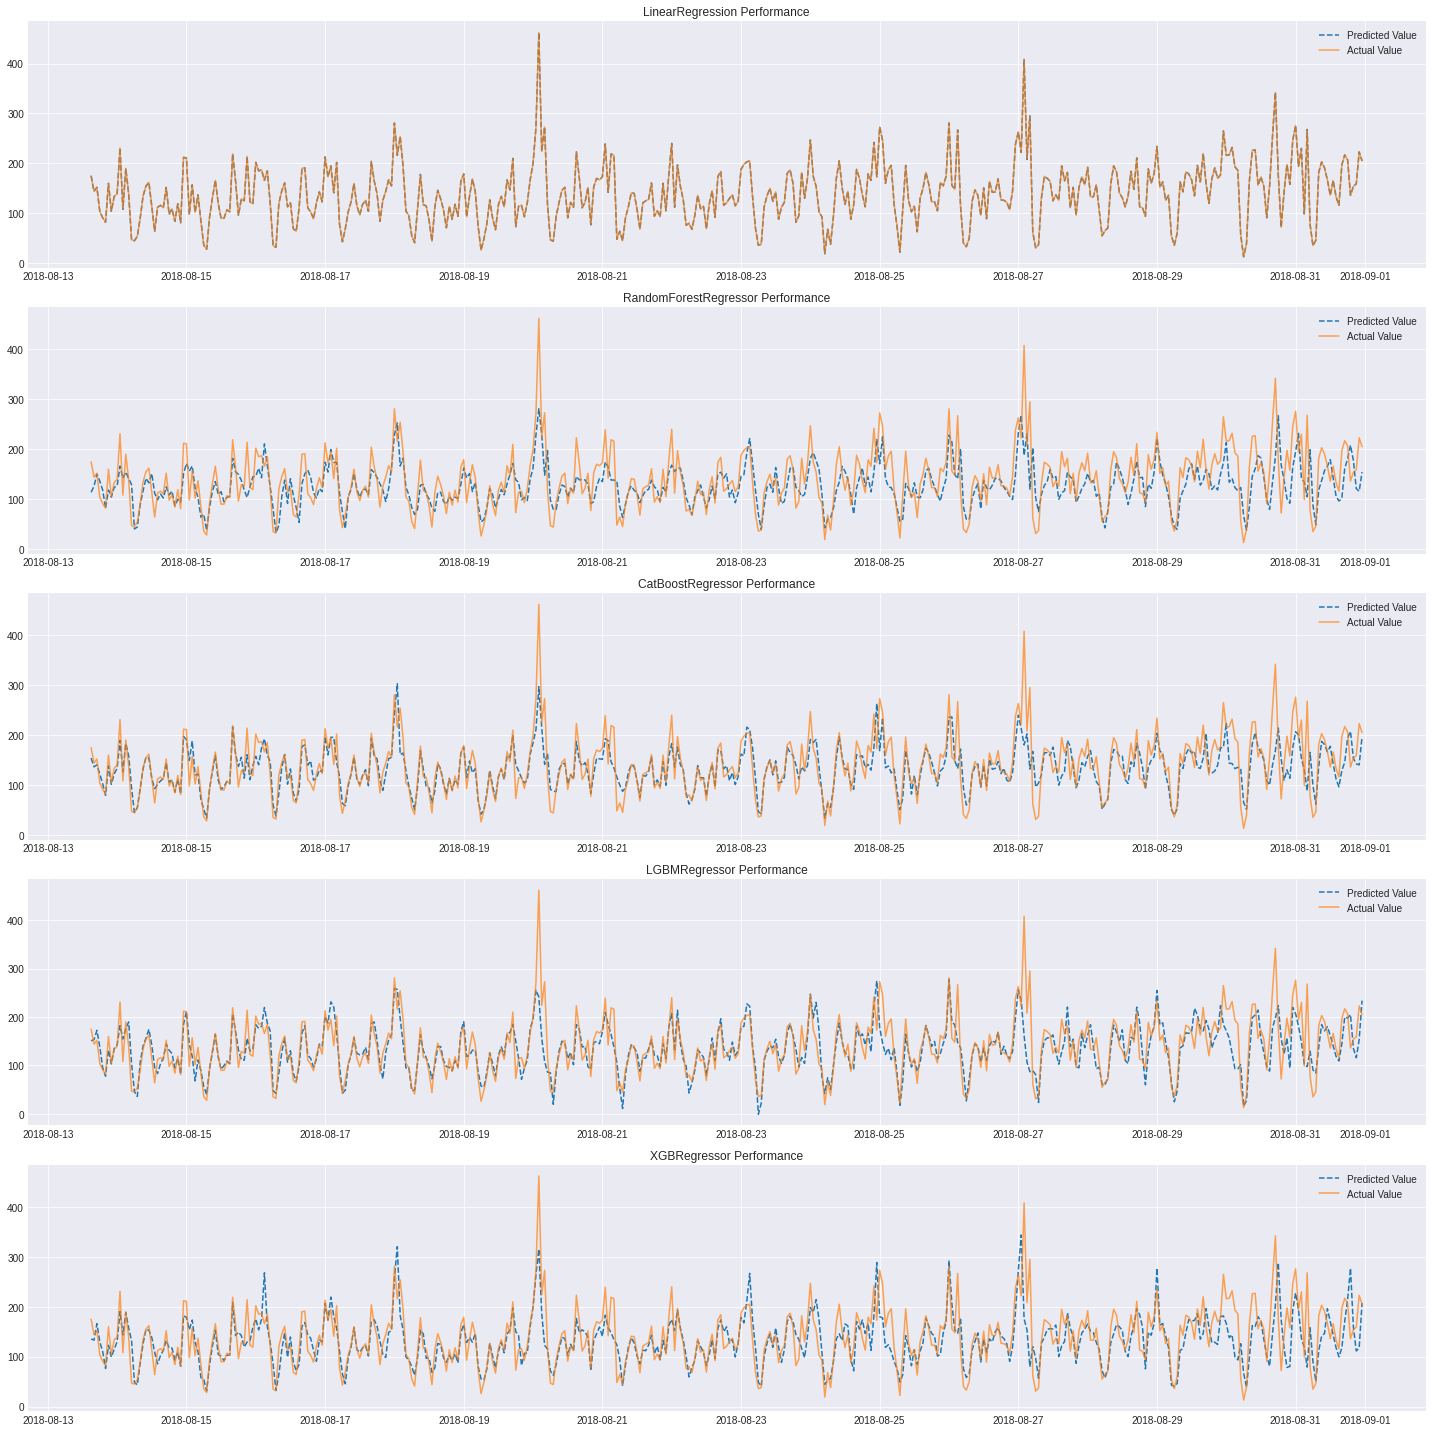

In [157]:
fig, axes = plt.subplots(5, 1, figsize=(20, 20))
for i, name, ax in zip(range(len(y_pred)), final_result['model_name'], axes.flatten()):
#     print(i)

    predict = pd.DataFrame(y_pred[i]).set_index(target_test.index)
    ax.plot(predict, label='Predicted Value', linestyle='--')
    ax.plot(target_test, label='Actual Value', alpha=.7)
    ax.set_title(f'{name} Performance') 
    ax.legend()
    
plt.tight_layout()
plt.show()

## Kesimpulan Umum

Pada project kali ini telah dilakukan analisis dan prediksi terhadap jumlah pesanan taksi disuatu bandara. Dalam analisis kita mendapatkan kesimpulan bahwa kecenderungan data ini memiliki trend yang naik (positive) walaupun kenaikannya tidak terlalu signifikan, akan tetapi bisa bisa menyimpulkan bahwa dari awal data hingga berakhirnya data terjadi peningkatan jumlah pesanan taksi yang didapatkan.

Untuk pesanan dalam data interval satu jam, kita menemukan pola bahwa jumlah pesanan paling sedikit selalu terjadi disekitar pukul 04:00 - 07:00. Sedangkan untuk pesanan dalam interval 1 hari kita mendapati 2 hari dalam seminggu dimana pesanan lebih sedikit dari pada hari lainnya, yaitu hari minggu dan selasa. Sedangkan untuk pesanan terbanyak biasanya terjadi dihari senin. 

Kemudian kita telah melakukan uji apakah data kita sudah stasioner atau bukan dengan menggunakan metode statistik ADF test sebelum modeling untuk melakukan prediksi jumlah pesanan dalam waktu jam-jam sibuk.

Dalam melakukan modeling ambang batas nilai RMSE adalah 48. Dengan nilai tersebut kita mendapatkan 5 algoritma yang memenuhi kriteria tersebut, adapun algoritma dan nilai metriks RMSEnya antara lain yaitu:
- LinearRegression	= 0.000000
- RandomForestRegressor	= 44.453162
- CatBoostRegressor	= 37.449701
- LGBMRegressor	= 38.176466
- XGBRegressor	= 42.323628

Berdasarkan hasil tersebut kita mendapati untuk algoritma yang bisa dikatakan sempurna adalah LinearRegression, karena model ini mampu memprediksi nilai yang hampir sangat mendekati nilai aktual dibanding ke-4 model lainnya. 

# Daftar Periksa Penilaian

- [x]  Jupyter Notebook bisa dibuka.
- [ ]  Tidak ada kesalahan dalam kode
- [ ]  Sel-sel dengan kode telah disusun berdasarkan urutan eksekusi.
- [ ]  Data telah diunduh dan disiapkan
- [ ]  Data telah dianalisis
- [ ]  Model sudah dilatih dan hiperparameter sudah dipilih
- [ ]  Model sudah dievaluasi. Kesimpulan sudah ada.
- [ ] *RMSE* untuk *test set* tidak lebih dari 48